## A basic set of tools for visualizing FESOM2.0 simulations

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
## import standard python packages

In [3]:
# import standard python packages
import sys
import numpy as np
# import basemap
from mpl_toolkits.basemap import Basemap
# import FESOM packages
sys.path.append("./modules/")
from load_mesh_data import *
from regriding import fesom2clim
sys.path.append("/home/h/hbkdsido/utils/seawater-1.1/")
import seawater as sw
from fesom_plot_tools import *
import cmocean.cm as cmo
import matplotlib 
fontsize=20
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

## read the mesh

In [5]:
# set the path to the mesh
#meshpath  ='/home/ollie/nkolduno/meshes/pi-grid/'
meshpath  ='/work/ollie/dsidoren/input/fesom2.0/meshes/mesh_CORE2_final/'
#meshpath  ='/work/ollie/ogurses/NATMAP/mesh_F2GLO08/'
alpha, beta, gamma=[50, 15, -90]
#alpha, beta, gamma=[0, 0, 0]
try:
	mesh
except NameError:
	print("mesh will be loaded")
	mesh=load_mesh(meshpath, abg=[alpha, beta, gamma], usepickle = False)
else:
	print("mesh with this name already exists and will not be loaded")

mesh will be loaded
Load 2d part of the grid in 1 second(s)


## Example 1
### plot the 2D slice of data at depth

ftriplot, number of dummy points: 60262


/home/ollie/nkolduno/miniconda2/envs/py35/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1800: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
./modules/fesom_plot_tools.py:62: RuntimeWarning: invalid value encountered in less_equal
  data2[data2<=contours.min()]=contours.min()+eps
./modules/fesom_plot_tools.py:63: RuntimeWarning: invalid value encountered in greater_equal
  data2[data2>=contours.max()]=contours.max()-eps


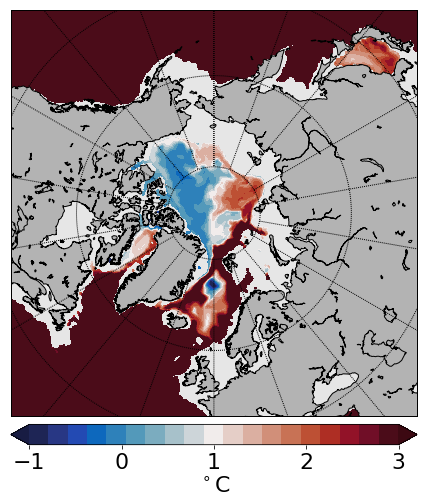

In [6]:
# set the paths to the results, runid, etc.
result_path ='/work/ollie/dsidoren/results/run_CORE2noGMSWHO_topo/'
runid ='fesom'
str_id='temp'

# specify depth, records and year to read
depth, records, year=300, np.linspace(0,0,1).astype(int), 1959

# set the label for the colorbar & contour intervals for ftriplot
cbartext, cont = '$^\circ$C', [-1., 3., .1]

# get the closest model depth to the desired one
ilev=ind_for_depth(depth, mesh)

# read the model result from str_id.XXXX.nc
data=read_fesom_slice(str_id, records, year, mesh, result_path, runid, ilev=ilev)

# choose the colorbar and plot the data
cmap=cmo.balance
fig =plt.figure(figsize=(12,8))

# ftriplot is defined in fesom_plot_tools.py
data[data==0]=np.nan
[im, map, cbar]=ftriplot(mesh, data, np.linspace(cont[0], cont[1], 20), oce='np', cmap=cmap)
cbar.set_label(cbartext, fontsize=22)
cbar.set_ticks([round(i,7) for i in np.linspace(cont[0], cont[1], 5)])
cbar.ax.tick_params(labelsize=22)

## Example 2
### comparing to climatology

./modules/climatology.py:83: RuntimeWarning: invalid value encountered in greater
  self.T = np.copy(ncfile.variables['temp'][:,:,:])
./modules/climatology.py:92: RuntimeWarning: invalid value encountered in greater
  self.S=np.copy(ncfile.variables['salt'][:,:,:])
/home/ollie/nkolduno/miniconda2/envs/py35/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/ollie/nkolduno/miniconda2/envs/py35/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


the model depth is:  1000 ; the closest depth in climatology is:  1000.0


./modules/fesom_plot_tools.py:99: RuntimeWarning: invalid value encountered in less_equal
  zz[zz<=contours.min()]=contours.min()+eps
./modules/fesom_plot_tools.py:100: RuntimeWarning: invalid value encountered in greater_equal
  zz[zz>=contours.max()]=contours.max()-eps
/home/ollie/nkolduno/miniconda2/envs/py35/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1800: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


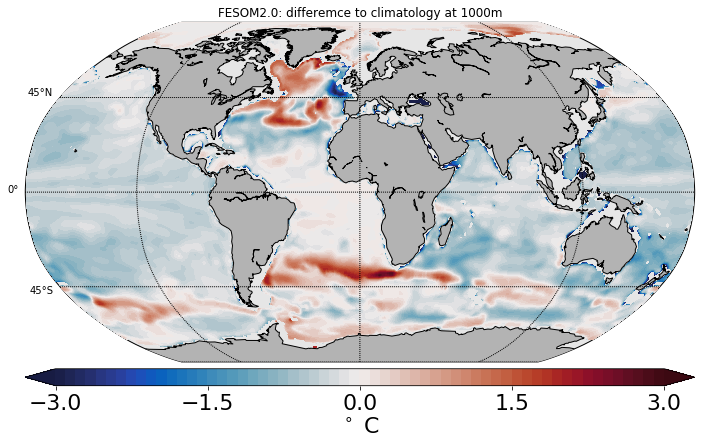

In [7]:
# read the climatology
from climatology import *
phc=climatology('phc3/', climname='phc')

# set the paths to the results, runid, etc.
result_path ='/work/ollie/dsidoren/results/run_CORE2noGMSWHO_topo/'
runid ='fesom'
str_id='temp'

# specify depth, records and year to read
depth, records, year=1000, np.linspace(0,0,1).astype(int), 1959

# set the label for the colorbar & contour intervals for ftriplot
cbartext, cont = '$^\circ$C', [-3., 3., .1]

# get the closest model depth to the desired one
ilev=ind_for_depth(depth, mesh)

# read the model result from str_id.XXXX.nc
data=read_fesom_slice(str_id, records, year, mesh, result_path, runid, ilev=ilev)

# interpolate the data onto the climatology grig
[iz, xx, yy, zz]=fesom2clim(data, depth, mesh, phc, radius_of_influence=10000000)

# plot the difference to climatology
cbartext=('$^\circ$ C' if (str_id=='temp') else 'psu')

# compute the difference to climatology (only T & S are supported)
dd=zz[:,:]-(phc.T[iz,:,:] if (str_id=='temp') else phc.S[iz,:,:])

# choose the colorbar and plot the data
cmap=cmo.balance

# wplot_xy is defined in fesom_plot_tools.py
fig = plt.figure(figsize=(12,8))
[im, map, cbar]=wplot_xy(xx,yy,dd,np.arange(cont[0], cont[1]+cont[2], cont[2]), cmap=cmap, do_cbar=True)
cbar.set_label(cbartext, fontsize=22)
cbar.set_ticks([round(i,4) for i in np.linspace(cont[0], cont[1], 5)])
cbar.ax.tick_params(labelsize=22)
plt.title('FESOM2.0: differemce to climatology at ' + np.str(depth)+'m')

## Example 3
### plot the norm of velocity (given on elements)

In [11]:
from numba import jit
@jit("float64[:](float64[:],int64, float64[:], int64[:,:], int64, float64[:])", nopython=True)
def tonodes(component, n2d, voltri, elem, e2d, lump2):
    ''' Function to interpolate from elements to nodes.
    Made fast with numba.
    '''
    onnodes=np.zeros(shape=n2d)

    var_elem=component*voltri
    for i in range(e2d):
        onnodes[elem[i,:]]=onnodes[elem[i,:]]+np.array([var_elem[i], var_elem[i], var_elem[i]])
    onnodes=onnodes/lump2/3.
    return onnodes

ftriplot, number of dummy points: 36210


./modules/fesom_plot_tools.py:34: RuntimeWarning: invalid value encountered in less_equal
  data2[data2<=contours.min()]=contours.min()+eps
./modules/fesom_plot_tools.py:35: RuntimeWarning: invalid value encountered in greater_equal
  data2[data2>=contours.max()]=contours.max()-eps


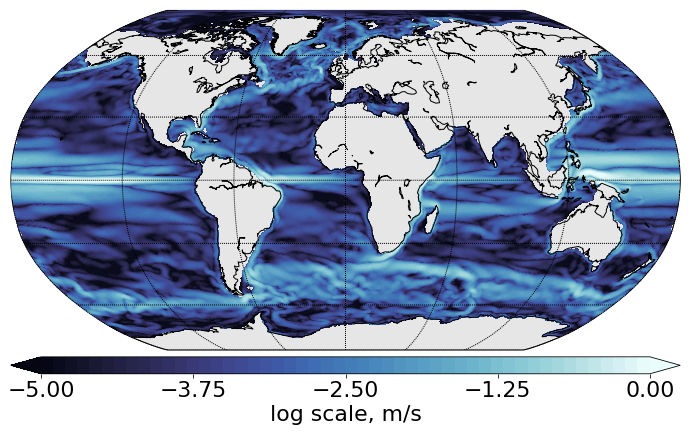

In [12]:
# set the paths to the results, runid, etc.
result_path ='/work/ollie/dsidoren/results/run_CORE2noGMSWHO_topo/'
runid ='fesom'

# specify depth, records and year to read
depth, records, year=100, np.linspace(0,0,1).astype(int), 1959

# set the label for the colorbar & contour intervals for ftriplot
cbartext, cont = 'log scale, m/s', [-5.,0., 0.1]

# get the closest model depth to the desired one
ilev=ind_for_depth(depth, mesh)

# read the ocean velocities
u=read_fesom_slice('u', records, year, mesh, result_path, runid, ilev=ilev)
v=read_fesom_slice('v', records, year, mesh, result_path, runid, ilev=ilev)
# one could use Dataset instead:
# f=Dataset('../results/run_8km_noGMHO/fesom.1960.oce.restart.nc')
# u=f.variables['u'][0,:,11]
# v=f.variables['v'][0,:,11]

# velocities on elements will be interpolated onto nodes
# allocate the nodal fields
unodes=np.zeros(shape=mesh.n2d)
vnodes=np.zeros(shape=mesh.n2d)

#  old and slow way to interpolate original velocities onto nods (unodes, vnodes)
# var_elem=u*mesh.voltri
# for i in range(mesh.e2d):
#     unodes[mesh.elem[i,:]]=unodes[mesh.elem[i,:]]+[var_elem[i], var_elem[i], var_elem[i]]
# unodes=unodes/mesh.lump2/3.

# var_elem=v*mesh.voltri
# for i in range(mesh.e2d):
#     vnodes[mesh.elem[i,:]]=vnodes[mesh.elem[i,:]]+[var_elem[i], var_elem[i], var_elem[i]]
# vnodes=vnodes/mesh.lump2/3.

#  new and fast way to interpolate original velocities onto nods (unodes, vnodes). Require numba. 
unodes = tonodes(u, mesh.n2d, mesh.voltri, mesh.elem, mesh.e2d, mesh.lump2)
vnodes = tonodes(v, mesh.n2d, mesh.voltri, mesh.elem, mesh.e2d, mesh.lump2)

# compute the absolute velocity
data=np.hypot(unodes, vnodes)

# plot the result
cmap=cmo.ice
fig = plt.figure(figsize=(12,8))
# ftriplot is defined in fesom_plot_tools.py
data[data==0]=np.nan
[im, map, cbar]=ftriplot(mesh, np.log(data), np.arange(cont[0], cont[1]+cont[2], cont[2]), oce='global', cmap=cmap)
cbar.set_label(cbartext, fontsize=22)
cbar.set_ticks([round(i,4) for i in np.linspace(cont[0], cont[1], 5)])
cbar.ax.tick_params(labelsize=22)

## Example 4
### plot a section

/home/ollie/nkolduno/miniconda2/envs/py35/lib/python3.5/site-packages/pyresample/kd_tree.py:383: UserWarning: Possible more than 10 neighbours within 300000 m for some data points
  (neighbours, radius_of_influence))
/home/ollie/nkolduno/miniconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


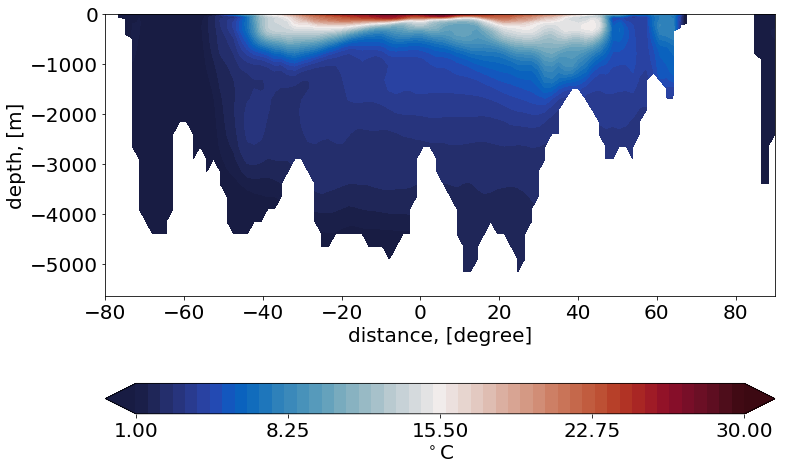

In [9]:
# set the paths to the results, runid, etc.
result_path ='/work/ollie/dsidoren/results/run_CORE2noGMSWHO_topo/'
runid ='fesom'
str_id='temp'

# specify records and year to read
records, year=np.linspace(0,0,1).astype(int), 1959

# set the label for the colorbar & contour intervals for ftriplot
cbartext, cont = '$^\circ$C', [1., 30., .1]

# define the section with points p1(x1,y1), p2(x2,y2)
p1=np.array([-30.,   -80.])
p2=np.array([-30.,    90.])

# set the number of descrete points in horizontal and vertical (nxy and nz, respectively) to represent the section
nxy=100
nz =46

# read thesection from the data
[sx, sy, sz]=read_fesom_sect(str_id, records, year, mesh, result_path, runid, p1, p2, nxy, nz, \
    how='mean', line_distance=5., radius_of_influence=300000)

# replace dummies with NaNs
sz[sz>1.e100]=np.nan

# plot the result
cmap=cmo.balance
fig = plt.figure(figsize=(12,8))
plt.contourf(sy, mesh.zlev[0:nz], sz, cmap=cmap, levels=np.linspace(cont[0], cont[1], 50), extend='both')
plt.xlabel('distance, [degree]', fontsize=fontsize)
plt.ylabel('depth, [m]', fontsize=fontsize)
cbar=plt.colorbar(orientation="horizontal", pad=.2)
cbar.set_ticks([round(i,4) for i in np.linspace(cont[0], cont[1], 5)])
cbar.set_label(cbartext, fontsize=fontsize)
cbar.set_label(cbartext, fontsize=fontsize)

## Example 5
### computing MOC from vertical velocity

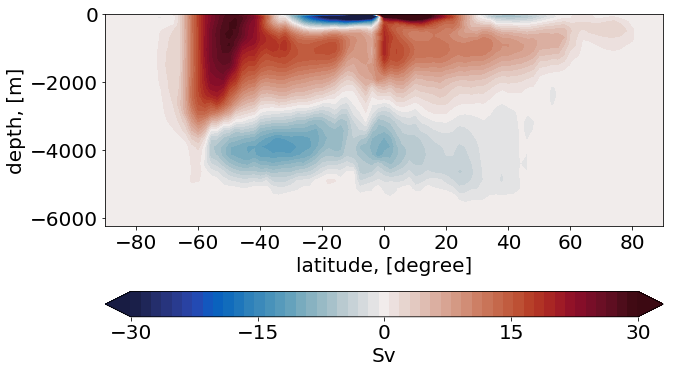

In [10]:
# set the paths to the results, runid, etc.
result_path ='/work/ollie/dsidoren/results/run_CORE2noGMSWHO_topo/'
runid ='fesom'

# set the label for the colorbar & contour intervals for ftriplot
cbartext, cont = 'Sv', [-30., 30., .5]

# define a descrete set of latitudes
nlats=91
lats=np.linspace(-90, 90, nlats)
dlat=lats[1]-lats[0]
# allocate moc array
moc=np.zeros([mesh.nlev, nlats])

# read the required metadata (mesh diagnostic file is always created at the cold start)
# grid information is needed for computing the MOC
ncfile  = Dataset(os.path.join(result_path, runid+'.mesh.diag.nc'))
el_area =ncfile.variables['elem_area'][:]
nlevels =ncfile.variables['nlevels'][:]-1
el_nodes=ncfile.variables['elem'][:,:]-1
nodes_x =ncfile.variables['nodes'][0,:]*180./np.pi
nodes_y =ncfile.variables['nodes'][1,:]*180./np.pi

# compute lon/lat coordinate of an element required lated for binning
elem_x  =nodes_x[el_nodes].sum(axis=0)/3.
elem_y  =nodes_y[el_nodes].sum(axis=0)/3.

# specify records and year to read
records, year=np.linspace(0,0,1).astype(int), 1959

# compute MOC
# precompute positions of elements for binning
pos = ((elem_y-lats[0])/dlat).astype('int')

# compute contributions from vertical velocities on elements and put them into bins
for i in range(mesh.nlev):
# read the model result from fesom.XXXX.oce.nc
    w=read_fesom_slice('w', records, year, mesh, result_path, runid, ilev=i)
#     print(i)
    # mean over elements
    elem_mean = np.sum(w[el_nodes[:,:]], axis=0)/3.*1.e-6
    # weigh by element area
    elem_mean_weigh = el_area*elem_mean
    # select nodes to consider in calculation based on number of levels
    toproc = np.where(i <=  nlevels-1)[0]
    # for every bin select elements that belong to the bin and sum them.
    for k in range(pos.min(), pos.max()+1):
#         if (i <= nlevels[e]-1):
            moc[i, k]=elem_mean_weigh[toproc][pos[toproc]==k].sum()

# the result from the previous step needs to be cumulatively summed 
moc = np.ma.cumsum(np.ma.masked_invalid(moc), axis=1)

# plot the result
cmap=cmo.balance
fig = plt.figure(figsize=(10,6))
plt.contourf(lats, mesh.zlev, moc, cmap=cmap, levels=np.linspace(cont[0], cont[1], 50), extend='both')
plt.xlabel('latitude, [degree]', fontsize=fontsize)
plt.ylabel('depth, [m]', fontsize=fontsize)
cbar=plt.colorbar(orientation="horizontal", pad=.2)
cbar.set_ticks([round(i,4) for i in np.linspace(cont[0], cont[1], 5)])
cbar.set_label(cbartext, fontsize=fontsize)
cbar.set_label(cbartext, fontsize=fontsize)    

## Auxuary things, manipulations with the topography
### closing the Gibraltar Strait by setting the depth there to 20m
### !mesh needs to be repartitioned afterwards!


In [ ]:
# find nodes around Gibraltar
ind=(mesh.x2 > -6.5) & (mesh.x2 < -3.5) & (mesh.y2 > 34.5) & (mesh.y2 < 37.5)
ind=[i for (i, val) in enumerate(ind) if (val)]

# read mesh topography from file (in case we do not trust already loaded mesh information data)
topofile='/work/ollie/dsidoren/input/fesom2.0/meshes/mesh_CORE2_final/aux3d.out'
with open(topofile) as f:
     nlev=int(next(f))
     zlev=np.array([next(f).rstrip() for x in range(nlev)]).astype(float)
     topo=np.array([next(f).rstrip() for x in range(mesh.n2d)]).astype(float)

# set depth around Gibraltar to 20m and save it into different mesh file
topo[ind]=topo[ind]=-20.

# create the new aux3d.out
topofile_new='/work/ollie/dsidoren/input/fesom2.0/meshes/mesh_CORE2_final/aux3d.out.new'
f = open(topofile_new, 'w')
f.write(str(nlev)+'\n')
for depth in zlev:
    f.write(str(depth)+'\n')   
for depth in topo:
    f.write(str(depth)+'\n')
f.close()

### increasing the amount of vertical levels to that from NEMO (74 levels)
### read the prepared on the mesh etopo5 topography
### skip the second and third level in order do improve CFL
### !mesh needs to be repartitioned afterwards!

In [ ]:
meshpath  ='/work/ollie/dsidoren/input/fesom2.0/meshes/mesh_CORE2_final/'
nf=Dataset(meshpath+'etopo.nc') # ETOPO5 topography already prepared
topo=nf.variables['topo'][:]
topo[topo >=     0]=-10.
topo[topo < -6500]=-6500.
# read the NEMO 74 vertical levels
nf=Dataset('/work/ollie/dsidoren/input/fesom2.0/NEMO_levels74.nc')
levels=-nf.variables['gdepw_0'][0,:]
# skip the very upper except for the first leveld in order to improve CFL
# add more depths
levels=np.concatenate((levels[[0, 4]], levels[5:], np.array([levels[-1]+levels[-1]-levels[-2], -6250])))
N=len(levels)

# create the new aux3d.out
topofile_new='/work/ollie/dsidoren/input/fesom2.0/meshes/mesh_CORE2_final/aux3d.out.etopo5N74'
f = open(topofile_new, 'w')
f.write(str(N)+'\n')
for depth in levels:
    f.write(str(depth)+'\n')   
for depth in topo:
    f.write(str(depth)+'\n')
f.close()